# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 14            
model_seed = 4           

# --- Training configuration ---
epochs = 200            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_CNN_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device=device
)

# CNN-specific initialization parameters
conv_channels = [32, 64]  # number of filters per conv layer
fc_dims = [128]           # fully connected layer sizes

# Grab model
model_template = model_module.get_model(
    conv_channels=conv_channels,
    fc_dims=fc_dims,
    device=device,
    seed=model_seed
)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = min(len(x_train), 1024)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=20,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/200: Train Loss 2.3001 | Test Loss 2.3396 | accs Train 0.1000 Test 0.1616


Epoch 20/200: Train Loss 0.0170 | Test Loss 1.3334 | accs Train 1.0000 Test 0.6855


Epoch 40/200: Train Loss 0.0002 | Test Loss 1.9318 | accs Train 1.0000 Test 0.7104


Epoch 60/200: Train Loss 0.0001 | Test Loss 2.1005 | accs Train 1.0000 Test 0.7085


Epoch 80/200: Train Loss 0.0001 | Test Loss 2.1391 | accs Train 1.0000 Test 0.7072


Epoch 100/200: Train Loss 0.0000 | Test Loss 2.1472 | accs Train 1.0000 Test 0.7079


Epoch 120/200: Train Loss 0.0000 | Test Loss 2.1481 | accs Train 1.0000 Test 0.7085


Epoch 140/200: Train Loss 0.0000 | Test Loss 2.1459 | accs Train 1.0000 Test 0.7092


Epoch 160/200: Train Loss 0.0000 | Test Loss 2.1421 | accs Train 1.0000 Test 0.7097


Epoch 180/200: Train Loss 0.0000 | Test Loss 2.1394 | accs Train 1.0000 Test 0.7106


Epoch 200/200: Train Loss 0.0000 | Test Loss 2.1372 | accs Train 1.0000 Test 0.7104
Completed training with 0 additional samples of data


Epoch 1/200: Train Loss 2.3153 | Test Loss 2.1649 | accs Train 0.0533 Test 0.2851


Epoch 20/200: Train Loss 0.2637 | Test Loss 0.4420 | accs Train 0.9367 Test 0.8794


Epoch 40/200: Train Loss 0.0382 | Test Loss 0.3431 | accs Train 0.9983 Test 0.9045


Epoch 60/200: Train Loss 0.0071 | Test Loss 0.3459 | accs Train 1.0000 Test 0.9170


Epoch 80/200: Train Loss 0.0028 | Test Loss 0.3569 | accs Train 1.0000 Test 0.9220


Epoch 100/200: Train Loss 0.0017 | Test Loss 0.3668 | accs Train 1.0000 Test 0.9232


Epoch 120/200: Train Loss 0.0012 | Test Loss 0.3743 | accs Train 1.0000 Test 0.9236


Epoch 140/200: Train Loss 0.0009 | Test Loss 0.3803 | accs Train 1.0000 Test 0.9238


Epoch 160/200: Train Loss 0.0008 | Test Loss 0.3856 | accs Train 1.0000 Test 0.9247


Epoch 180/200: Train Loss 0.0006 | Test Loss 0.3904 | accs Train 1.0000 Test 0.9253


Epoch 200/200: Train Loss 0.0005 | Test Loss 0.3947 | accs Train 1.0000 Test 0.9255
Completed training with 540 additional samples of data
Epoch 1/200: Train Loss 2.2579 | Test Loss 2.0112 | accs Train 0.1430 Test 0.5648


Epoch 20/200: Train Loss 0.1579 | Test Loss 0.2251 | accs Train 0.9530 Test 0.9318


Epoch 40/200: Train Loss 0.0277 | Test Loss 0.1494 | accs Train 0.9975 Test 0.9573


Epoch 60/200: Train Loss 0.0066 | Test Loss 0.1488 | accs Train 1.0000 Test 0.9608


Epoch 80/200: Train Loss 0.0029 | Test Loss 0.1554 | accs Train 1.0000 Test 0.9622


Epoch 100/200: Train Loss 0.0017 | Test Loss 0.1606 | accs Train 1.0000 Test 0.9626


Epoch 120/200: Train Loss 0.0011 | Test Loss 0.1652 | accs Train 1.0000 Test 0.9632


Epoch 140/200: Train Loss 0.0008 | Test Loss 0.1690 | accs Train 1.0000 Test 0.9634


Epoch 160/200: Train Loss 0.0006 | Test Loss 0.1724 | accs Train 1.0000 Test 0.9637


Epoch 180/200: Train Loss 0.0005 | Test Loss 0.1754 | accs Train 1.0000 Test 0.9638


Epoch 200/200: Train Loss 0.0004 | Test Loss 0.1782 | accs Train 1.0000 Test 0.9640
Completed training with 1940 additional samples of data
Epoch 1/200: Train Loss 1.8481 | Test Loss 1.0697 | accs Train 0.4925 Test 0.7312


Epoch 20/200: Train Loss 0.0414 | Test Loss 0.0985 | accs Train 0.9888 Test 0.9706


Epoch 40/200: Train Loss 0.0054 | Test Loss 0.0903 | accs Train 0.9998 Test 0.9757


Epoch 60/200: Train Loss 0.0016 | Test Loss 0.0994 | accs Train 1.0000 Test 0.9767


Epoch 80/200: Train Loss 0.0008 | Test Loss 0.1057 | accs Train 1.0000 Test 0.9771


Epoch 100/200: Train Loss 0.0005 | Test Loss 0.1116 | accs Train 1.0000 Test 0.9775


Epoch 120/200: Train Loss 0.0003 | Test Loss 0.1156 | accs Train 1.0000 Test 0.9777


Epoch 140/200: Train Loss 0.0002 | Test Loss 0.1193 | accs Train 1.0000 Test 0.9779


Epoch 160/200: Train Loss 0.0002 | Test Loss 0.1222 | accs Train 1.0000 Test 0.9777


Epoch 180/200: Train Loss 0.0001 | Test Loss 0.1246 | accs Train 1.0000 Test 0.9778


Epoch 200/200: Train Loss 0.0001 | Test Loss 0.1271 | accs Train 1.0000 Test 0.9778
Completed training with 5940 additional samples of data


Epoch 1/200: Train Loss 1.0136 | Test Loss 0.3859 | accs Train 0.6998 Test 0.8864


Epoch 20/200: Train Loss 0.0125 | Test Loss 0.0456 | accs Train 0.9974 Test 0.9859


Epoch 40/200: Train Loss 0.0011 | Test Loss 0.0468 | accs Train 1.0000 Test 0.9863


Epoch 60/200: Train Loss 0.0003 | Test Loss 0.0532 | accs Train 1.0000 Test 0.9861


Epoch 80/200: Train Loss 0.0001 | Test Loss 0.0568 | accs Train 1.0000 Test 0.9865


Epoch 100/200: Train Loss 0.0001 | Test Loss 0.0597 | accs Train 1.0000 Test 0.9864


Epoch 120/200: Train Loss 0.0001 | Test Loss 0.0622 | accs Train 1.0000 Test 0.9862


Epoch 140/200: Train Loss 0.0000 | Test Loss 0.0642 | accs Train 1.0000 Test 0.9863


Epoch 160/200: Train Loss 0.0000 | Test Loss 0.0668 | accs Train 1.0000 Test 0.9863


Epoch 180/200: Train Loss 0.0000 | Test Loss 0.0679 | accs Train 1.0000 Test 0.9860


Epoch 200/200: Train Loss 0.0000 | Test Loss 0.0699 | accs Train 1.0000 Test 0.9865
Completed training with 19940 additional samples of data


Epoch 1/200: Train Loss 0.4824 | Test Loss 0.1309 | accs Train 0.8609 Test 0.9597


Epoch 20/200: Train Loss 0.0066 | Test Loss 0.0315 | accs Train 0.9981 Test 0.9905


Epoch 40/200: Train Loss 0.0002 | Test Loss 0.0382 | accs Train 1.0000 Test 0.9912


Epoch 60/200: Train Loss 0.0000 | Test Loss 0.0426 | accs Train 1.0000 Test 0.9913


Epoch 80/200: Train Loss 0.0000 | Test Loss 0.0460 | accs Train 1.0000 Test 0.9910


Epoch 100/200: Train Loss 0.0000 | Test Loss 0.0479 | accs Train 1.0000 Test 0.9912


Epoch 120/200: Train Loss 0.0000 | Test Loss 0.0509 | accs Train 1.0000 Test 0.9911


Epoch 140/200: Train Loss 0.0000 | Test Loss 0.0532 | accs Train 1.0000 Test 0.9912


Epoch 160/200: Train Loss 0.0000 | Test Loss 0.0558 | accs Train 1.0000 Test 0.9914


Epoch 180/200: Train Loss 0.0000 | Test Loss 0.0588 | accs Train 1.0000 Test 0.9908


Epoch 200/200: Train Loss 0.0000 | Test Loss 0.0616 | accs Train 1.0000 Test 0.9911
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 2.1372 | accs: 0.7104
 540 samples | Test Loss: 0.3947 | accs: 0.9255
1940 samples | Test Loss: 0.1782 | accs: 0.9640
5940 samples | Test Loss: 0.1271 | accs: 0.9778
19940 samples | Test Loss: 0.0699 | accs: 0.9865


59940 samples | Test Loss: 0.0616 | accs: 0.9911



=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0005 | accs: 1.0000
 Model 1940 | Train Loss: 0.0002 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 2.1527 | accs: 0.7333
 Model  540 | Train Loss: 0.0005 | accs: 1.0000
 Model 1940 | Train Loss: 0.0004 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000

Dataset type: data, additional samples: 1940
 Model    0 | Train Loss: 2.3754 | accs: 0.6980
 Model  540 | Train Loss: 0.3098 | accs: 0.9360
 Model 1940 | Train Loss: 0.0004 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0000 | accs: 1.0000


 Model    0 | Train Loss: 2.3044 | accs: 0.6992
 Model  540 | Train Loss: 0.3998 | accs: 0.9228
 Model 1940 | Train Loss: 0.1851 | accs: 0.9621
 Model 5940 | Train Loss: 0.1066 | accs: 0.9819


 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000

Dataset type: data, additional samples: 59940


 Model    0 | Train Loss: 2.3311 | accs: 0.6983
 Model  540 | Train Loss: 0.4209 | accs: 0.9201


 Model 1940 | Train Loss: 0.2092 | accs: 0.9588
 Model 5940 | Train Loss: 0.1312 | accs: 0.9775


 Model 19940 | Train Loss: 0.0590 | accs: 0.9908
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000


### Model + Data Specific Verification

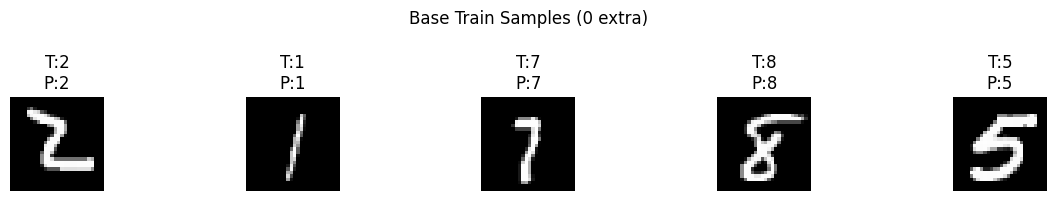

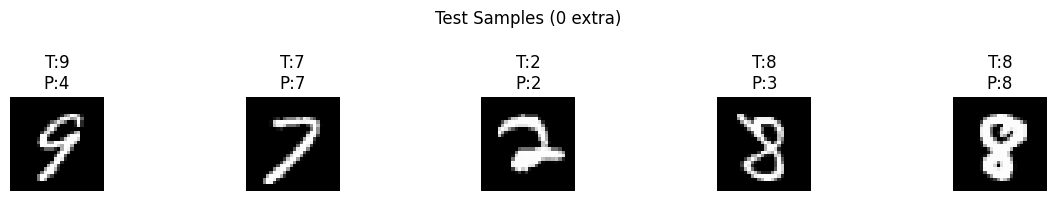

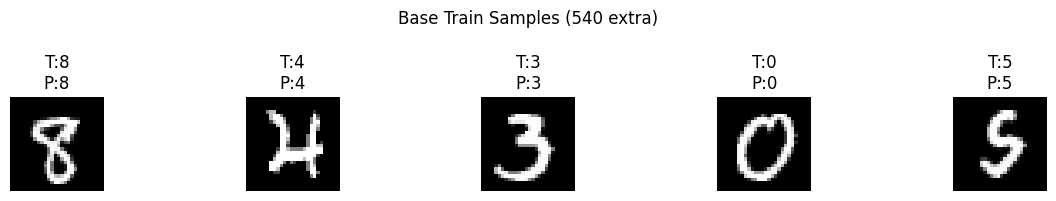

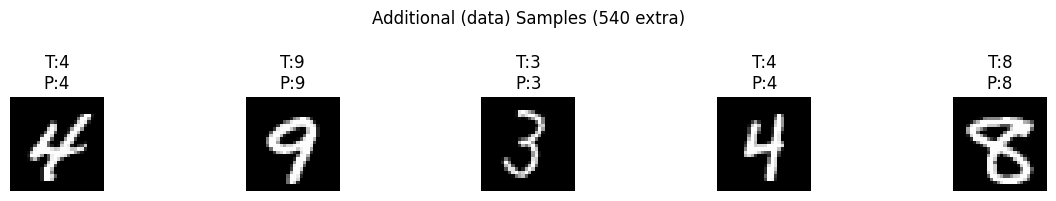

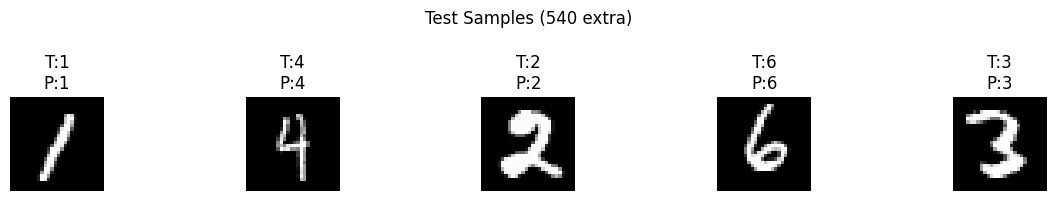

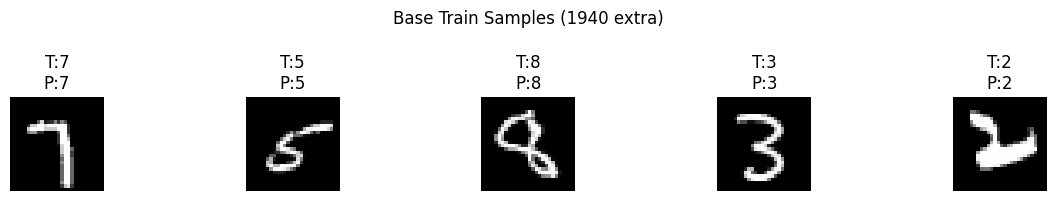

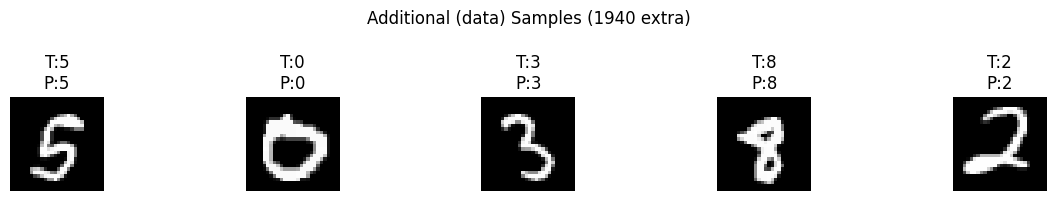

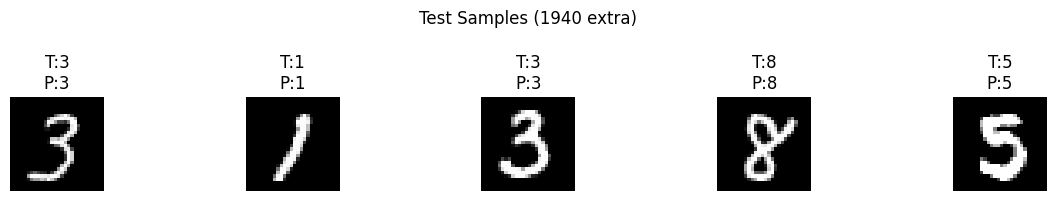

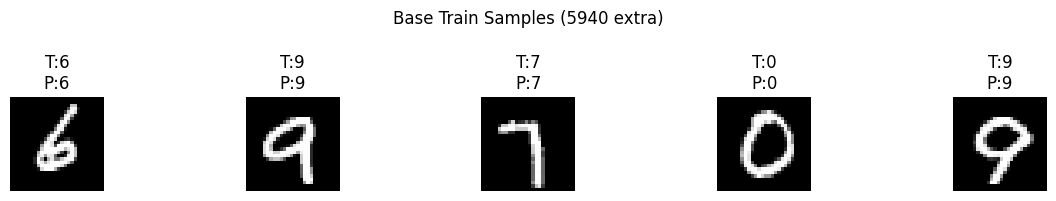

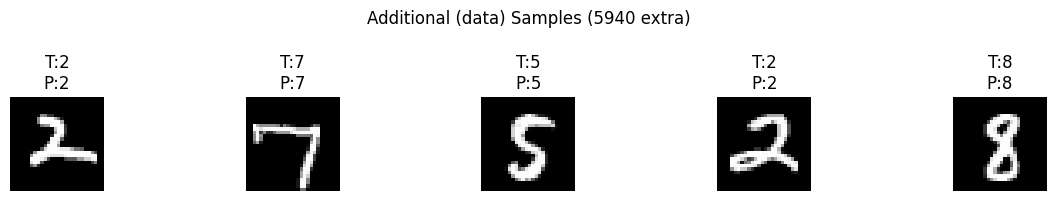

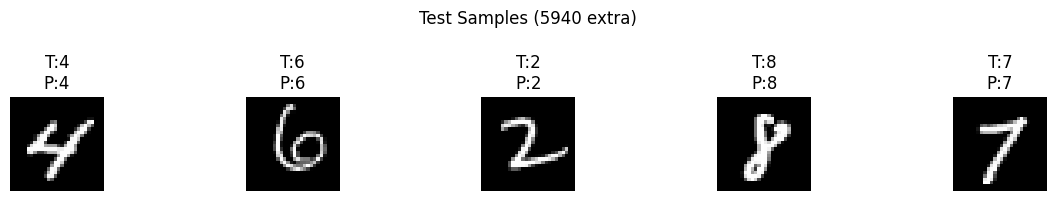

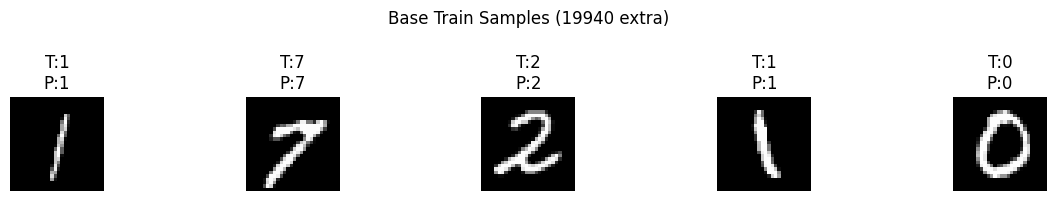

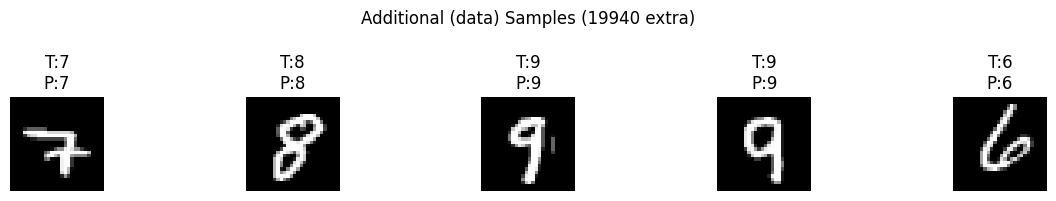

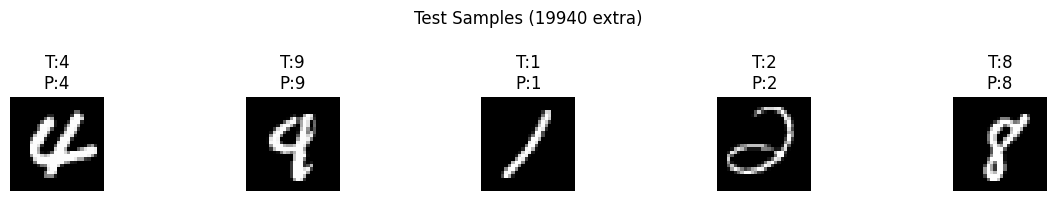

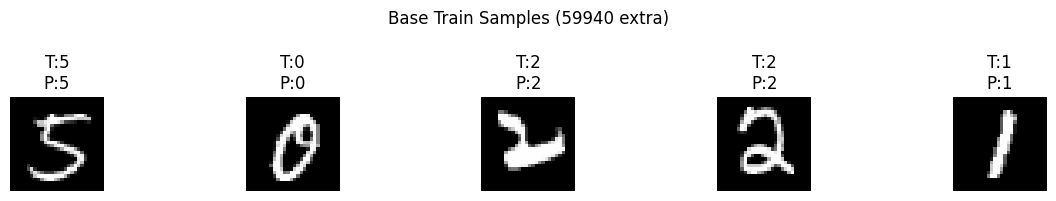

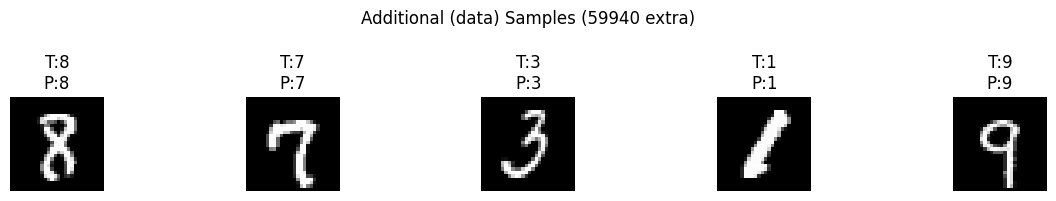

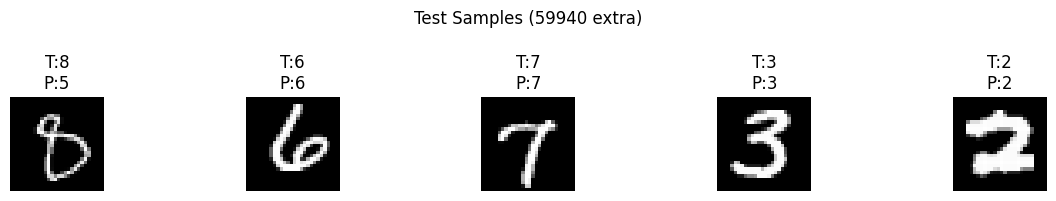

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
